## Feature selection done by eXtreme Gradient Boosting (XGBoost)


In [68]:
import sys
import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split, RepeatedStratifiedKFold, RepeatedKFold, cross_val_score, cross_validate
from sklearn.pipeline import Pipeline

from xgboost import XGBRegressor, plot_importance
import pickle
import matplotlib.pyplot as plt


sys.path.insert(0, "../../")
import utils.utils_feature_selection as fs
import utils.utils_evaluation as e
import utils.settings as s

s.init()
seed = s.seed

pd.set_option('display.max_columns', None)
plt.figure(figsize=(20, 10))


import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

<Figure size 2000x1000 with 0 Axes>

In [69]:
df_candidates = pd.read_excel("../../input_survey_data/input_data_business.xlsx")
df_candidates.tail(2)


,Target_contentloss_euro,Target_businessreduction,inundation_duration_h,water_depth_cm,contaminations.0,contaminations.1,contaminations.2,contaminations.3,contaminations.4,flowvelocity,warning_time_h,emergency_measures.1,emergency_measures.2,emergency_measures.3,emergency_measures.4,emergency_measures.6,emergency_measures.7,emergency_measures.8,emergency_measures.9,overall_problem_house,protect_valuables_impl,water_barriers_impl,pumping_equipment_impl,elevation_building_impl,resistant_material_building_impl,electricity_higher_impl,flood_protections_impl,flood_experience,elevation_building_height_cm,elevation_rel2surrounding_cat,bage,b_area,hh_monthly_income_cat,shp_owner,shp_sector,shp_employees,shp_avgmonthly_sale_cat,shp_finance_investments,shp_suppliers_location.1,shp_suppliers_location.2,shp_suppliers_location.3,shp_suppliers_location.4,shp_suppliers_location.5,shp_profits_last5years,shp_risk_tolerance,shp_monetary_resources4prevention,resilience_city_protection,resilience_more_future_affected,resilience_govern_warnings_helpful,resilience_govern_careing,resilience_govern_careing_increases,resilience_left_alone,resilience_neighbor_management,perception_who_responsible4protection.Rank1,perception_who_responsible4protection.Rank2,perception_govern_support_past,perception_govern_support_future,perception_private_economy_future,shp_content_value_euro,shp_registered_capital_euro,elevation_m
395,0.0,NaN,4.0,70.0,0,1,0,0,1,1,NaN,1,0,1,0,1,0,0,0,1,1,5,1,1,5,5,5,5,70.0,1,NaN,130.0,NaN,1,17,2,3,1,1,1,0,0,0,4.0,3.0,3.0,1.0,5.0,1.0,1.0,1.0,5,1.0,2.0,2.0,NaN,1.0,3.0,NaN,11047.7,1.83886
396,0.0,0.0,3.0,100.0,0,1,0,0,1,1,NaN,1,0,1,0,0,0,0,0,0,1,5,5,5,5,5,5,4,NaN,0,5.0,33.0,1.0,1,11,2,3,1,1,1,0,0,0,4.0,3.0,4.0,NaN,NaN,NaN,NaN,NaN,5,NaN,3.0,2.0,NaN,NaN,3.0,NaN,736.5,1.87277


In [70]:
## delete features with more than 10% missing values

# print(df_candidates.isna().sum(axis=0).sort_values(ascending=False))
df_candidates = df_candidates[df_candidates.columns[df_candidates.isna().mean() < 0.10]]  # drop feautres with more than 10% missing values
print(df_candidates.isna().sum(axis=0).sort_values(ascending=False))

## --> drop content values if threshold == e.g 15%

Target_businessreduction                       36
perception_who_responsible4protection.Rank1    28
shp_risk_tolerance                             28
bage                                           27
perception_private_economy_future              26
hh_monthly_income_cat                          24
resilience_govern_careing                      23
resilience_govern_warnings_helpful             18
shp_monetary_resources4prevention              18
resilience_more_future_affected                15
resilience_city_protection                     15
shp_profits_last5years                         15
Target_contentloss_euro                        11
resilience_neighbor_management                 11
inundation_duration_h                           9
elevation_m                                     4
b_area                                          2
water_depth_cm                                  1
emergency_measures.8                            0
emergency_measures.1                            0


## Fit model 

In [71]:
param_grid = {'n_estimators': [10, 100, 200, 500],
              'max_depth': [1, 2, 3, 5, 10,20],
              'colsample_bytree': [0.1, 0.3, 0.5, 0.7, 1.0],
              'colsample_bynode': [0.1, 0.3], # nbr of feautres for each split point
              'learning_rate': [0.1, 0.3, 0.5],  # == eta
              'gamma': [1, 4, 8] , # min_split_loss -  larger gamma is, the more conservative the algorithm is
              #'subsample': 0.8  # define subsample of train st, xgb has not bootstrapping
              'reg_alpha': [0, 90, 180],   # Lasso Regularization term on weights 
              'reg_lambda': [0.0, 0.5, 1.0],
              'min_child_weight': [0, 3, 5, 10],
              }

In [72]:
## iterate over both targets and store results 

targets = ["Target_contentloss_euro", "Target_businessreduction"]
importances_threshold = {"Target_contentloss_euro": 0.000, "Target_businessreduction": 0.000 }

fi_plots =  {"Target_contentloss_euro": None, "Target_businessreduction": None }

for target in targets:

    print( f"\nApply XGBoost on {target}:")

    df_candidates_t = df_candidates

   
    ## TEST run xgb with and without nan
    ## clean df from remaining records containg nan
    #df_candidates_t = df_candidates_t.dropna()
    #df_candidates_t = df_candidates_t[df_candidates_t[target]!=0.0]

    print("Amount of missing target values should be zero: ", df_candidates_t[target].isna().sum())
    print("Uses ", df_candidates_t.shape[0], " records, from those have ", 
          { (df_candidates_t[target][df_candidates_t[target]==0.0]).count() }, f" records zero {target.split('_')[1]}")


    X_unscaled = df_candidates_t.drop(targets, axis=1)  # remove targets from X
    y = df_candidates_t[target]
     
    ## test train split
    X_train, X_test, y_train, y_test = train_test_split(
        X_unscaled, y, test_size=0.10, 
        random_state=seed, shuffle=True
    )
    ## normalize data 
    X_train, X_test = fs.normalize_X(X_train, X_test)

    ## classes have to start from zero on
    le = LabelEncoder()
    y_train = le.fit_transform(y_train)

 
    ## Fit model 
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=seed) # cv method TODO find better method maybe RepeatedStratifiedKFold
    model_cv = RandomizedSearchCV(
        XGBRegressor(
            #early_stopping_rounds=10,
            random_state=seed
            ),  # eval_metric=mean_absolute_error,
        param_distributions=param_grid, 
        #cv = 5,  # add cv=5 again as soon scarce samples are removed
        cv=cv, 
        scoring="neg_mean_absolute_error"
    )
    ## TODO remove from target samples which occure less than one time
                                    
    model_cv.fit(X_train, y_train)#, #eval_metric=mean_absolute_error,)
    print(f"Best hyperparams: {model_cv.best_params_}")
    print("Train R^2 Score : %.1f" %model_cv.best_estimator_.score(X_train, y_train))
    print("MAE of best model: %.1f" %model_cv.best_score_," on iteration ", model_cv.best_estimator_.best_iteration)  

    # fit model again with best hyperparams
    print("Create new XGBoost model based on best hyperparameters")
    model = XGBRegressor(n_estimators = model_cv.best_params_['n_estimators'], 
                        max_depth = model_cv.best_params_['max_depth'],
                        colsample_bynode = model_cv.best_params_['colsample_bynode'],
                        learning_rate = model_cv.best_params_['learning_rate'],
                        random_state=seed
                        )
    model.fit(X_train, y_train)
    
    ## store best trained model for evaluation
    filename = f'./models_trained/xgboost_{target}.sav'
    #pickle.dump(model_cv.best_estimator_, open(filename, 'wb'))
    pickle.dump(model, open(filename, 'wb'))

    ## Evaluate model
    print(f"Training set score (R^2): {round(model.score(X_train, y_train), 2)}")  # how well did the model on the training set
    #print(f"Test set score (R^2): {model_cv.score(X_test, y_test)}")   # .. compared to the unseen test set for overfitting - acutal not needed
    # r2 = variance explained by model / total variance --> higher r2= better fitted model


    ## get signifcant features based on absolute coeff values
    print("\nSelect features based on absolute feature importance")

    # ## select significant features by using coefs (= linear relationship between features ~ target, adjusted by the regularization terms)
    # df_importance = pd.DataFrame({
    #     "importances" : np.abs(model_cv.best_estimator_.coef_), # larger absolute coef value == more important feature
    #     }, index= X_unscaled.columns.to_list())
    # df_importance = df_importance.loc[df_importance.importances > importances_threshold[target], : ].T      # drop features which dont reduce the loss

    # ## write selected predictors and response to disk
    # X_train = pd.DataFrame(X_train)
    # X_train.columns = X_unscaled.columns
    # y_train = pd.DataFrame(y_train)
    # y_train.columns = [target]
    # save_selected_features(X_train, y_train, df_importance.columns, filename=f"../../input_survey_data/fs_xgboost_{target.split('_')[1]}.xlsx")


    ## evaluate
    # scores = cross_validate(elastic_net, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1) # neg_mean_absolute_error
    # print(scores)
    # # force scores to be positive
    # #scores = np.abs(scores)
    # #print('Mean MAE: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

    #plt.subplots(figsize=(10,12))
    # plot_importance(model_cv.best_estimator_)
    # #plt.show()
    # plt.savefig(f"./models_trained/FI_{target}.png", bbox_inches='tight')




Apply XGBoost on Target_contentloss_euro:
Amount of missing target values should be zero:  11
Uses  397  records, from those have  {226}  records zero contentloss


Best hyperparams: {'reg_lambda': 0.0, 'reg_alpha': 90, 'n_estimators': 500, 'min_child_weight': 3, 'max_depth': 20, 'learning_rate': 0.1, 'gamma': 1, 'colsample_bytree': 0.7, 'colsample_bynode': 0.3}
Train R^2 Score : 0.9
MAE of best model: -17.9  on iteration  499
Create new XGBoost model based on best hyperparameters
Training set score (R^2): 1.0

Select features based on absolute feature importance

Apply XGBoost on Target_businessreduction:
Amount of missing target values should be zero:  36
Uses  397  records, from those have  {149}  records zero businessreduction
Best hyperparams: {'reg_lambda': 0.5, 'reg_alpha': 0, 'n_estimators': 100, 'min_child_weight': 0, 'max_depth': 10, 'learning_rate': 0.1, 'gamma': 4, 'colsample_bytree': 0.7, 'colsample_bynode': 0.3}
Train R^2 Score : 1.0
MAE of best model: -5.6  on iteration  99
Create new XGBoost model based on best hyperparameters
Training set score (R^2): 1.0

Select features based on absolute feature importance


In [73]:
#plt.savefig(f"./models_trained/FI_{target}.png", bbox_inches='tight')
#sns_plot.figure.savefig("output.png")
model.score(X_train, y_train)
model.score(X_train, y_train)


0.9997785574811319

### Evaluation

In [74]:
## reload models

target = targets[1]
print(target)

model_eval = pickle.load(open(f"./models_trained/xgboost_{target}.sav", 'rb'))
#model_eval.get_params()
#dir(model_eval)#.feature_importances_[model_eval.feature_importances_>0.015].shape

Target_businessreduction


In [75]:
model_eval

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=0.3,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [113]:
## drop samples where target is nan from X and y testing set
y_test = y_test.reset_index(drop=True)
nan_idx = y_test[pd.isna(y_test)].index.to_list()
y_test = y_test.dropna()
X_test = X_test.iloc[~X_test.index.isin(nan_idx)]
print(f"Dropped {len(nan_idx)} records from testing set due that these values are nan in target variable")


y_pred = model_eval.predict(X_test)

Dropped 3 records from testing set due that these values are nan in target variable


In [115]:
## print evaluation report + check for overfitting 
print("\nTesting set")
e.evaluation_report(y_test, y_pred)

# r2 how well pred fit to observed 
y_pred_train = model_cv.best_estimator_.predict(X_train)
print("\nTraining set")
e.evaluation_report(y_train, y_pred_train)


Testing set

    Model Performance:
        Mean Squared Error: 360.5
        Root Mean Square Error: 19.0
        Mean Absolute Error: 12.0
        Mean Absolute Percentage Error: inf
        R²-Score: 0.2
    

Training set

    Model Performance:
        Mean Squared Error: 0.6
        Root Mean Square Error: 0.8
        Mean Absolute Error: 0.6
        Mean Absolute Percentage Error: inf
        R²-Score: 1.0
    


### Feature importance
Have the same feature importance method across all applied ML models


##### Hierarchical clustering on Spearman rank correlation

Select only feautres with low collienarity to solve disadvantage of perumation feature importance.
Randomizing one feature would lead to only small importance score - the model performance wouldnt be move influenced - due that the information is included in other correlated features. Removing one feature keeps the similar inforamtion in the other feautres unchanged and the model learns from the correlated feature. Therefore apply hierachical clustering to select less correlated features

See also:
- Brill 2020 (dissertation)
- https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html # code example

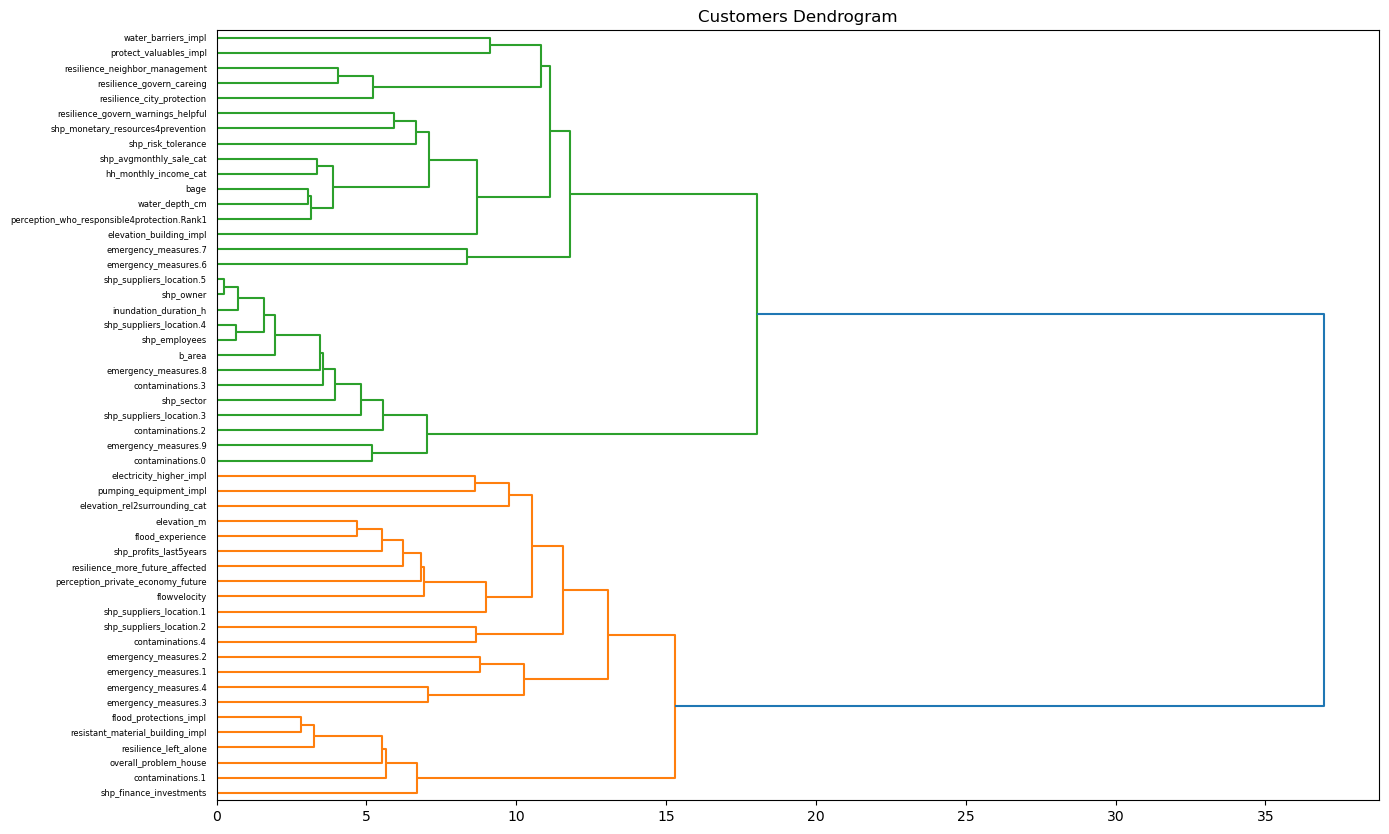

In [233]:
import scipy.cluster.hierarchy as shc

plt.figure(figsize=(15, 10))
plt.title("Customers Dendrogram")

# Selecting Annual Income and Spending Scores by index
selected_data = X_train.dropna()
selected_data = selected_data.T # only possible with out nan
clusters = shc.linkage(selected_data, 
            method='ward', optimal_ordering=False,
            metric="euclidean")
shc.dendrogram(Z=clusters, 
               #p=20, # p -> value for truncation mode
               orientation="right",
               labels=X_train.columns
               ) 
plt.show()

## TODO adapt with spearman rank order

In [227]:
type(clusters)

numpy.ndarray

TypeError: ward() got an unexpected keyword argument 'checks'

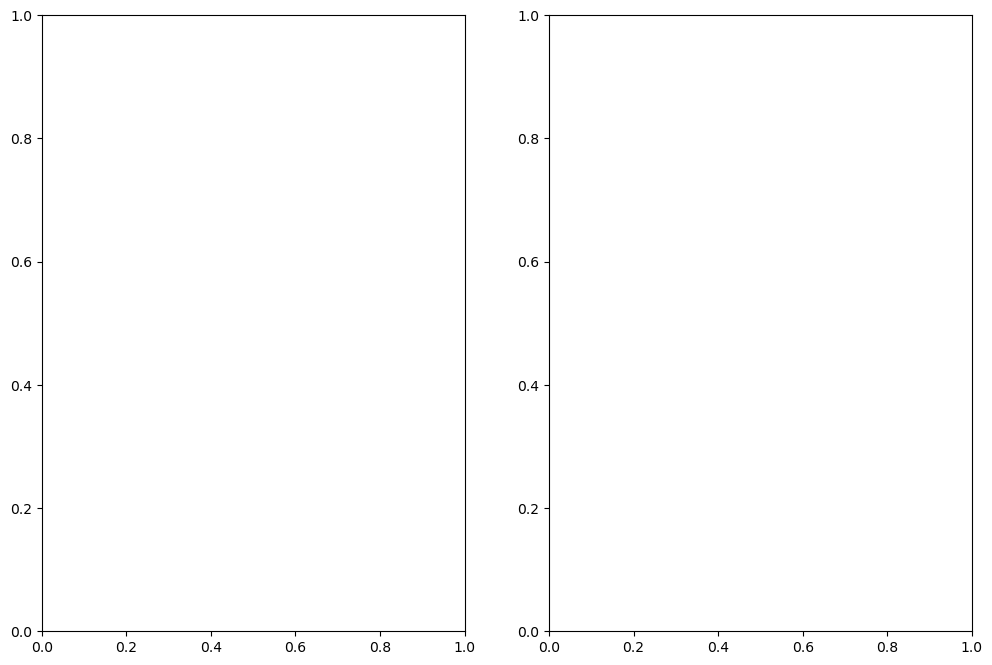

In [223]:
# from scipy.stats import spearmanr
# from scipy.spatial.distance import squareform
# from scipy.cluster.hierarchy import ward, dendrogram

# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
# corr = spearmanr(X_unscaled_no_nan).correlation

# # Ensure the correlation matrix is symmetric
# corr = (corr + corr.T) / 2
# np.fill_diagonal(corr, 1)

# # We convert the correlation matrix to a distance matrix before performing
# # hierarchical clustering using Ward's linkage.
# distance_matrix = 1 - np.abs(corr)
# dist_linkage = ward(distance_matrix, checks=False )
# dendro = dendrogram(
#     dist_linkage, labels=X_unscaled_no_nan.columns.tolist(), ax=ax1, leaf_rotation=90
# )
# dendro_idx = np.arange(0, len(dendro["ivl"]))

# ax2.imshow(corr[dendro["leaves"], :][:, dendro["leaves"]])
# ax2.set_xticks(dendro_idx)
# ax2.set_yticks(dendro_idx)
# ax2.set_xticklabels(dendro["ivl"], rotation="vertical")
# ax2.set_yticklabels(dendro["ivl"])
# fig.tight_layout()


In [214]:
cluster_ids = shc.fcluster(distance_matrix, 1, criterion="distance")


ValueError: Linkage matrix 'Z' must have 4 columns.

In [ ]:
cluster_ids = shc.fcluster(dist_linkage, 1, criterion="distance")
cluster_id_to_feature_ids = defaultdict(list)
for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(idx)
selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]

X_train_sel = X_train[:, selected_features]
X_test_sel = X_test[:, selected_features]


In [ ]:
## Permuation feature importance
result = e.permutation_feature_importance(model_eval, X_test, y_test, repeats=5, seed=seed)

df_importances = pd.DataFrame(result.importances_mean, index=X_test.columns, columns=['importances'])#.transpose()
df_importances = df_importances.sort_values("importances", ascending=False)  # get most important features to the top


AttributeError: importance_mean

In [24]:
result

NameError: name 'result' is not defined

In [188]:
t = pd.DataFrame(importances_mean, index=X_test.columns, columns=['importances'])
t.sort_values("importances", ascending=False).head(5)

,importances
elevation_m,0.199733
water_depth_cm,0.117569
bage,0.116713
b_area,0.096127
shp_risk_tolerance,0.080050


In [194]:
np.random.seed(seed)
import copy

y_pred = model.predict(X_train)

print(f"Train set score (R^2): {model.score(X_train, y_train)}")   
#print(f"Test set score (R^2): {model.score(X_test, y_test)}")   # .. compare to the unseen test set for overfitting

import utils.utils_evaluation as e
fi = e.permutation_feature_importance(model, X_train, y_train, y_pred, mean_squared_error)
fi.sort_values("importances", ascending=False).head(4)



Train set score (R^2): -0.617814303641457


,importances
shp_suppliers_location.2,11.710894
shp_employees,11.672992
shp_suppliers_location.3,11.529147
shp_risk_tolerance,11.360970


In [18]:
model_eval.feature_importances_#.argsort()


array([0.01722084, 0.02426116, 0.01142127, 0.02055015, 0.00139399,
       0.00556864, 0.01633769, 0.01026317, 0.0012005 , 0.01310099,
       0.00561102, 0.00184334, 0.01562625, 0.0173521 , 0.00944406,
       0.03107774, 0.11193128, 0.02532803, 0.01406536, 0.01999517,
       0.0151386 , 0.03100536, 0.02005674, 0.00677337, 0.01849343,
       0.00261462, 0.03159421, 0.01706447, 0.0172437 , 0.05205282,
       0.01523139, 0.01795498, 0.01478818, 0.00826742, 0.0236318 ,
       0.00460709, 0.01920517, 0.03582786, 0.        , 0.0209697 ,
       0.04501307, 0.01353768, 0.02865515, 0.02482001, 0.0217543 ,
       0.02181592, 0.00651418, 0.02180882, 0.02235811, 0.01013516,
       0.03747382], dtype=float32)

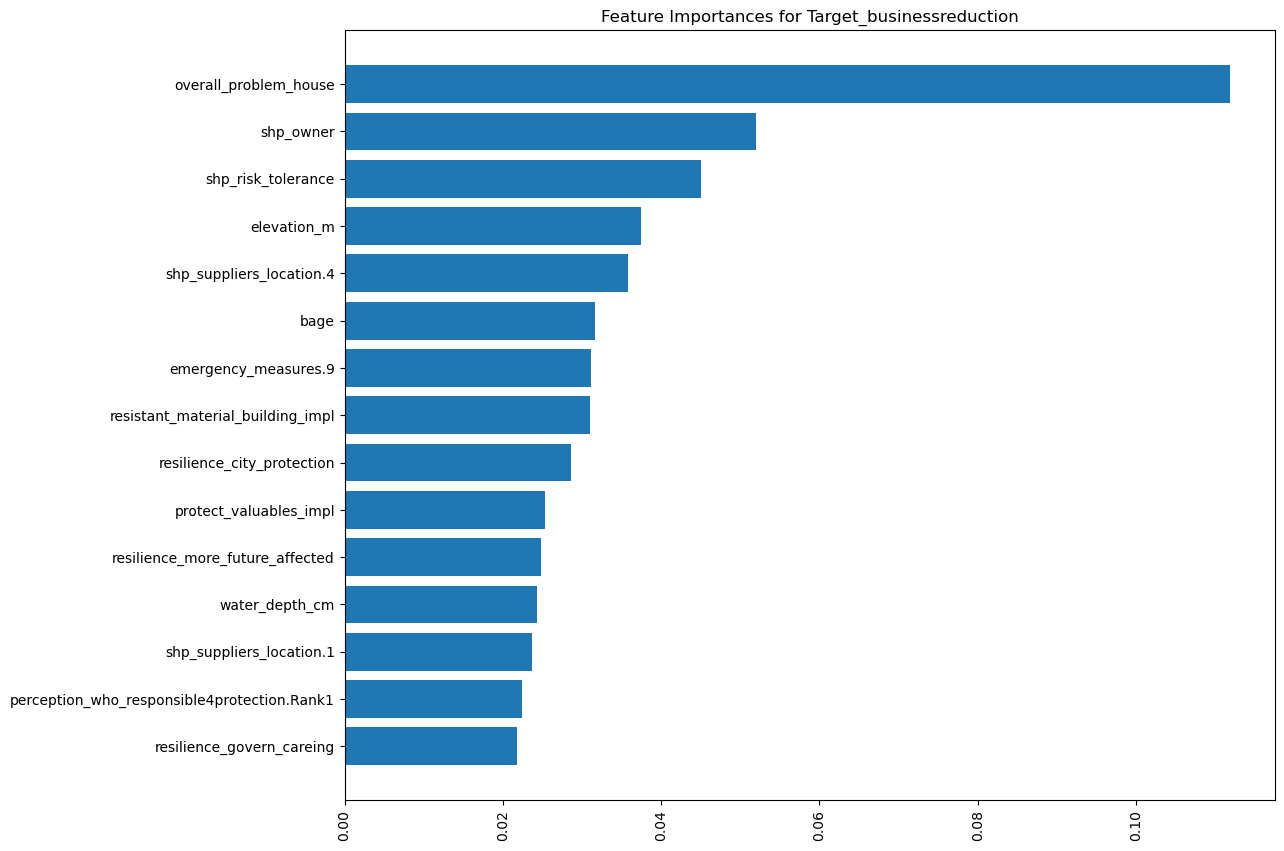

In [19]:
# plot feature importance
fig, ax = plt.subplots(figsize=(12,10))

# ## coef of feature importances
df_importance = pd.DataFrame({
    "name" : X_train.columns.to_list(),
    "importances" : model_eval.feature_importances_,
     }) 
  

# drop features which dont reduce the loss
#df_importance = df_importance.loc[df_importance.importances > 0.015, : ] 
df_importance = df_importance.sort_values("importances", ascending=True)
#sorted_idx = model_eval.feature_importances_.argsort()
plt.barh(df_importance.name[-15:], df_importance.importances[-15:])
#plt.barh(df_importance.columns, model_eval.feature_importances_)
#plt.bar(X_train.columns[sorted_idx[:15]], model_eval.feature_importances_[sorted_idx[:15]])
plt.xticks(
   # ticks = range(len(X_train.columns[sorted_idx[:15]])),
   # labels =X_train.columns[sorted_idx[:15],],
    rotation = 90
    )
plt.title(f"Feature Importances for {target}")

plt.show()

In [11]:
## permutation based FI (build in func from skilearn)

# perm_importance = permutation_importance(xgb, X_test, y_test)
# The visualization of the importance:

# sorted_idx = perm_importance.importances_mean.argsort()
# plt.barh(boston.feature_names[sorted_idx], perm_importance.importances_mean[sorted_idx])
# plt.xlabel("Permutation Importance")